In [1]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.0


In [2]:
data_news_headlines = pd.read_json("../shared_data/x1.json")

# Adjust news headline data
data_news_headlines = data_news_headlines.drop(columns='article_link', axis=1)
data_news_headlines = data_news_headlines.rename(columns ={'headline':'text', 'is_sarcastic':'label'})
data_news_headlines = data_news_headlines.reindex(columns=['text','label'])
data_news_headlines.head()

,text,label
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [3]:
data_tweets = pd.read_csv("../shared_data/dataset_csv.csv")

# Adjust tweets data
data_tweets = data_tweets.rename(columns={'tweets':'text'})
data_tweets.head()

,text,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [4]:
data_sitcoms = pd.read_csv("../shared_data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [5]:
data_reddit = pd.read_csv("../shared_data/train-balanced-sarcasm.csv")

# Adjust reddit data
data_reddit = data_reddit.drop(columns=['author','subreddit','score','ups','downs','date','created_utc','parent_comment'], axis=1)
data_reddit = data_reddit.rename(columns={'comment':'text'})
data_reddit = data_reddit.reindex(columns=['text','label'])

data_reddit.head()

,text,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme isn't funny none of the ""new york ni...",0
4,I could use one of those tools.,0


In [25]:
# Combine all 4 datasets
data = pd.concat([data_news_headlines,data_tweets,data_sitcoms,data_reddit], ignore_index=True)

# Shuffle the rows
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,text,label
0,Infrastructure will be great with Christie,1.0
1,I feel there is a joke I'm missing.,0.0
2,hard-ly ftfy lololol,1.0
3,*laughs a bit and glows gold* OOC: I was nerfe...,1.0
4,The body magically passes through the titanium...,1.0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042641 entries, 0 to 1042640
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   text    1042588 non-null  object 
 1   label   1042641 non-null  float64
dtypes: float64(1), object(1)
memory usage: 15.9+ MB


In [27]:
##create arrays to store the headlines and labels
text = list(data['text'])
labels = list(data['label'])
#text_dataset = tf.data.Dataset.from_tensor_slices(text)

In [28]:
##define the parameters for tokenizing and padding
vocab_size = 100000
embedding_dim = 32
max_length = 120
padding_type = 'post'
trunc_type='post'
oov_tok = "<OOV>"
training_size = 200000

In [29]:
##create the text vectorization layer and create the vocab
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, standardize='lower_and_strip_punctuation', split='whitespace', output_mode='int', output_sequence_length=max_length)

vectorize_layer.adapt(text)

In [30]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 120)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 120, 32)           3200000   
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                792       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,200,817
Trainable params: 3,200,817
No

In [31]:
##training set from 0 to training size
training_sentences = text[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = text[training_size:]
testing_labels = labels[training_size:]

In [32]:
num_epochs = 30
history = model.fit(
    training_sentences, 
    training_labels, 
    epochs=num_epochs, 
    validation_data=(testing_sentences, testing_labels)
    )

Epoch 1/30
6250/6250 [==============================] - 304s 48ms/step - loss: 0.6232 - accuracy: 0.6451 - val_loss: 0.5960 - val_accuracy: 0.6814
Epoch 2/30
6250/6250 [==============================] - 292s 47ms/step - loss: 0.5732 - accuracy: 0.7008 - val_loss: 0.6053 - val_accuracy: 0.6672
Epoch 3/30
6250/6250 [==============================] - 286s 46ms/step - loss: 0.5505 - accuracy: 0.7181 - val_loss: 0.6007 - val_accuracy: 0.6772
Epoch 4/30
6250/6250 [==============================] - 290s 46ms/step - loss: 0.5305 - accuracy: 0.7336 - val_loss: 0.6060 - val_accuracy: 0.6824
Epoch 5/30
6250/6250 [==============================] - 301s 48ms/step - loss: 0.5147 - accuracy: 0.7442 - val_loss: 0.6148 - val_accuracy: 0.6730
Epoch 6/30
6250/6250 [==============================] - 301s 48ms/step - loss: 0.5001 - accuracy: 0.7542 - val_loss: 0.6132 - val_accuracy: 0.6785
Epoch 7/30
6250/6250 [==============================] - 301s 48ms/step - loss: 0.4864 - accuracy: 0.7625 - val_loss: 0

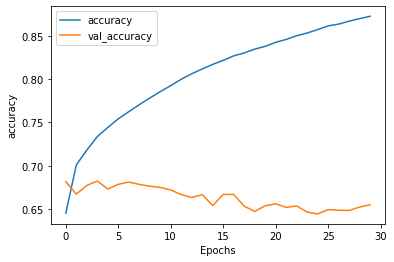

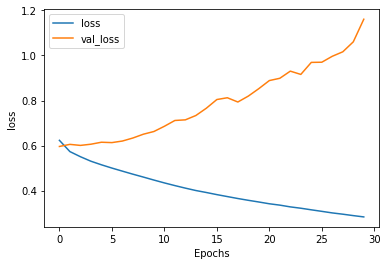

In [33]:
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [34]:
sentences = ["Now we know why some animals eat their own children.", "game of thrones season finale showing this sunday night","Please, keep talking. I always yawn when I am interested."]
print(model.predict(sentences))

1/1 [==============================] - 0s 94ms/step
[[4.5445493e-01]
 [7.5673595e-02]
 [1.0994176e-04]]


In [35]:
model.save('./model_saves')

INFO:tensorflow:Assets written to: ./model\assets
